### Часть 1 - сбор датасета

In [1]:
# ячейка импортов

! pip3 install requests
! pip3 install beautifulsoup4 
import requests as rq
from bs4 import BeautifulSoup
import pandas as pd

from statistics import mean

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score, RepeatedStratifiedKFold
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn import metrics

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
russian_stopwords = stopwords.words('russian')

import string
import re
import pymorphy2

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [79]:
# списки, в которых хранится информация
reviews = []
scores = []
rating_value = []
rating_count = []
year = []
title = []

In [80]:
# функция, собирающая дополнительную информацию 

def lib_info_add(soup):

# рейтинг книги - общий
    for rat_v in soup.find("span", attrs={'itemprop' : 'ratingValue'}):
        rating_value.append(rat_v.text)

# количество прочитавших
    for rat_c in soup.find("span", attrs={'itemprop' : 'ratingCount'}):
        rating_count.append(rat_c.text)
    
# год выхода
    for ye in soup.find("span", attrs={'itemprop' : 'datePublished'}):
        year.append(ye.text)

# название
    for name in soup.find("span", attrs={'itemprop' : 'name'}):
        title.append(name.text)

In [82]:
#  функция, забирающая всю нужную информацию

def lib_info(url):
    
    page = rq.get(url) 
    soup = BeautifulSoup(page.text, 'html.parser')
    
    
    for score in soup.find_all("div", class_ = "response-autor-mark"):
        i = len(score.text)
        scores.append(score.text[i-1])
    
    for review in soup.find_all("div", class_ = "response-body-home"):
        reviews.append(review.text)

        lib_info_add(soup)
    
    

In [83]:
# парсинг сайта фантлаба

for i in range(0, 15000):
    url = "https://fantlab.ru/work"+str(i)
    lib_info(url)

In [84]:
# немного исправить оценки - 0 заменить на 10

marks = scores
for index,item in enumerate(marks):
    if item =='0':
        marks[index] = '10'

In [85]:
# в некоторых рецензиях нет рейтинга (он не числовой, а 'нет') - заменить его на среднее

numeric_score = []

for i in marks:
    if i.isnumeric() == True:
        numeric_score.append(int(i))

mean_score = int(mean(numeric_score)+0.5)

for index,item in enumerate(marks):
    if item =='т':
        marks[index] = str(mean_score)

In [86]:
# датафрейм

book_df_add = pd.DataFrame(title)
book_df_add.rename(columns={0:'Names'}, inplace = True)
book_df_add['Average_rating'] = rating_value
book_df_add['Read_by'] = rating_count
book_df_add['Year'] = year
book_df_add['Review'] = reviews
book_df_add['Score'] = marks

In [118]:
book_df.to_csv('everything_with_clean_values.csv', encoding ="utf-8")

### Часть 2 - обработка данных

In [2]:
# чтобы заново не совершать парсинг, считываю датасет из файла
book_df = pd.read_csv(r"C:\Users\marus\Desktop\everything_with_clean_values.csv", encoding ='utf-8')

In [4]:
book_df.drop(['Unnamed: 0'], axis = 1, inplace = True)

In [57]:
book_df["Text"] = book_df.Review.str.lower()

In [58]:
book_df.Text

0        \nтот, кто будет читать этот роман как жанрову...
1        \nни за что бы не сел за написание отзыва к эт...
2        \nдаа, а я уж думал, что я старый, умудренный ...
3        \nнаверное, после «гипериона» читать что-то ещ...
4        \nроман мне не понравился. с научной фантастик...
                               ...                        
15674    \nзамечательная идея, интересная!:glasses:врем...
15675    \nбиоинженерная мысль приколола, неплохой рома...
15676    \nочень не обычный сюжет...\rот этого книгу ещ...
15677    \nнеплохой фантастическо-шпионский роман. есть...
15678    \nидея живых домов, живых мобилей, живых вещей...
Name: Text, Length: 15679, dtype: object

In [63]:
# отбрасываем ненужные символы - цифры, латинские буквы, знаки препинания, 
english = (r'[a-z]+')
digits = (r'\d+')
punctuation = (r'[^\w\s]')
extra = (r'\n?')
symbols = (r'[\n\xa0]')
extra_spaces = (r'\s{2,}')
# мб знаки препинания по-другому?
# word.strip(string.punctuation))

book_df.Text = book_df.Text.str.replace(english, ' ')
book_df.Text = book_df.Text.str.replace(digits, ' ')
book_df.Text = book_df.Text.str.replace(punctuation, ' ')
book_df.Text = book_df.Text.str.replace(extra, '')
book_df.Text = book_df.Text.str.replace(symbols, ' ')
book_df.Text = book_df.Text.str.replace(extra_spaces, ' ')

C:\Users\marus\AppData\Local\Temp/ipykernel_7732/3120310610.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  book_df.Text = book_df.Text.str.replace(english, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_7732/3120310610.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  book_df.Text = book_df.Text.str.replace(digits, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_7732/3120310610.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  book_df.Text = book_df.Text.str.replace(punctuation, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_7732/3120310610.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  book_df.Text = book_df.Text.str.replace(extra, '')
C:\Users\marus\AppData\Local\Temp/ipykernel_7732/3120310610.py:15: FutureWarning: The default value of regex will change from True t

In [5]:
book_df.Text

0        тот кто будет читать этот роман как жанровую ф...
1        ни за что бы не сел за написание отзыва к этой...
2        даа а я уж думал что я старый умудренный жизне...
3        наверное после гипериона читать что то еще в ж...
4        роман мне не понравился с научной фантастикой ...
                               ...                        
16850    совсем не впечатлило там где автор старается б...
16851    это книга из серии детская литература после ше...
16852    не асилил брал после черного спецназа который ...
16853    книга в достаточной степени серая но не совсем...
16854    примитивная и пустая пьеса о жизни зеленых и с...
Name: Text, Length: 16855, dtype: object

In [65]:
# Лемматизация

morph = pymorphy2.MorphAnalyzer()

In [66]:
clean_lemmas =[]

In [127]:
clean_lemmas = []

In [68]:
for sentence in book_df.Text:
    sent = list(sentence.split())
    sen = []
    for word in sent:
        lemma = morph.parse(word)[0].normal_form
        sen.append(lemma)
    clean_lemmas.append(sen)

In [70]:
book_df['Lemmas'] = clean_lemmas

In [76]:
# book_df.Lemmas[15674]

['замечательный',
 'идея',
 'интересный',
 'временами',
 'правда',
 'книга',
 'нудновата',
 'продолжение',
 'читать',
 'интерес']

In [75]:
# Убрать стоп-слова

book_df.Lemmas = book_df.Lemmas.apply(lambda x: [item for item in x if item not in russian_stopwords])

In [6]:
# Смотрим получившийся датасет

book_df

,Names,Average_rating,Read_by,Year,Review,Score,Text,Lemmas
0,Гиперион,8.68,9259,1989,"\nТот, кто будет читать этот роман как жанрову...",10,тот кто будет читать этот роман как жанровую ф...,"['читать', 'роман', 'жанровый', 'фантастика', ..."
1,Гиперион,8.68,9259,1989,\nНи за что бы не сел за написание отзыва к эт...,2,ни за что бы не сел за написание отзыва к этой...,"['сесть', 'написание', 'отзыв', 'книга', 'зашк..."
2,Гиперион,8.68,9259,1989,"\nДаа, а я уж думал, что я старый, умудренный ...",10,даа а я уж думал что я старый умудренный жизне...,"['даа', 'думать', 'старый', 'умудрить', 'жизне..."
3,Гиперион,8.68,9259,1989,"\nНаверное, после «Гипериона» читать что-то ещ...",10,наверное после гипериона читать что то еще в ж...,"['наверное', 'гиперион', 'читать', 'ещё', 'жан..."
4,Гиперион,8.68,9259,1989,\nРоман мне не понравился. С научной фантастик...,6,роман мне не понравился с научной фантастикой ...,"['роман', 'понравиться', 'научный', 'фантастик..."
...,...,...,...,...,...,...,...,...
16850,Чёрный спецназ,6.68,87,2007,"\nСовсем не впечатлило. Там, где автор старает...",6,совсем не впечатлило там где автор старается б...,"['впечатлить', 'автор', 'стараться', 'серьёзны..."
16851,Планета по имени Тигрис,7.48,31,1984,\nЭто книга из серии «Детская литература». Пос...,6,это книга из серии детская литература после ше...,"['это', 'книга', 'серия', 'детский', 'литерату..."
16852,Пульт мертвеца,6.90,75,1988,"\nне асилил. Брал после Черного Спецназа, кото...",5,не асилил брал после черного спецназа который ...,"['асилила', 'брать', 'чёрный', 'спецназ', 'кот..."
16853,Зелёные и серые,6.23,34,2004,"\nКнига, в достаточной степени серая, но не со...",5,книга в достаточной степени серая но не совсем...,"['книга', 'достаточный', 'степень', 'серый', '..."


In [200]:
# book_df.to_csv('everything_with_clean_values.csv', encoding = 'utf-8')

<AxesSubplot:ylabel='Original scores'>

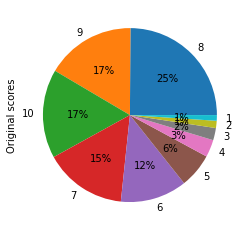

In [7]:
# Статистика по классам

classes = pd.value_counts(book_df.Score.values)
classes.plot(kind = 'pie',  autopct='%0.f%%', label = 'Original scores') 

### Часть 3 - векторизация

In [202]:
# Шаг 3 - векторизация

input_text = list(book_df.Lemmas.values)
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(input_text)]

In [203]:
# Применение модели Doc2Vec

model_doc = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)
model_doc.save("model_doc")
vectors = []
for x in documents:
    vec = list(model_doc.dv[x.tags][0])
    vectors.append(vec)

In [204]:
vectors

[[1.2159346, -1.0169792, -0.57561076, 0.8363148, 0.44855195],
 [0.5377818, 0.09014924, -0.6659171, 1.4653974, 1.0552458],
 [0.9477955, 0.17668602, -0.7880299, -0.10854327, 0.09851755],
 [0.16491058, 0.48486117, -0.5126696, -0.10383299, 0.56541765],
 [0.49953026, -0.0528485, -0.44248652, 0.21412107, 0.39443865],
 [1.400876, -0.5617412, -0.62759143, 1.8739742, 0.3948259],
 [1.1046737, 0.004265965, -0.90760094, 0.022632487, 0.810366],
 [0.39390346, 0.35600424, -1.276499, 0.7527828, 0.75934714],
 [0.9152111, 0.398352, -0.39489865, -0.50018567, 0.4612396],
 [0.46129623, -0.046508722, -1.0045218, 0.29530707, 0.35595524],
 [0.93264604, 0.8310406, -0.8552428, 0.075003274, 0.49853563],
 [0.6734577, 0.4714995, -0.84327835, 0.8925873, 1.083742],
 [0.54122275, 0.2565775, -0.4205959, 0.12911198, 0.8268995],
 [0.87190515, 0.35798275, -0.50017977, 0.2577943, 0.40605375],
 [0.100273944, -0.39130652, -0.61777776, -0.18244852, 0.4552069],
 [1.2441686, 0.61697763, -1.0195912, 2.1417623, 0.54647523],
 [0.

In [205]:
split_df = pd.DataFrame(vectors, columns=['v1', 'v2', 'v3','v4',"v5"])
result_doc = book_df.join(split_df, how='left')

In [206]:
result_doc

,Names,Average_rating,Read_by,Year,Review,Score,Text,Lemmas,v1,v2,v3,v4,v5
0,Гиперион,8.68,9259,1989,"\nТот, кто будет читать этот роман как жанрову...",10,тот кто будет читать этот роман как жанровую ф...,"[читать, роман, жанровый, фантастика, разочаро...",1.215935,-1.016979,-0.575611,0.836315,0.448552
1,Гиперион,8.68,9259,1989,\nНи за что бы не сел за написание отзыва к эт...,2,ни за что бы не сел за написание отзыва к этой...,"[сесть, написание, отзыв, книга, зашкаливать, ...",0.537782,0.090149,-0.665917,1.465397,1.055246
2,Гиперион,8.68,9259,1989,"\nДаа, а я уж думал, что я старый, умудренный ...",10,даа а я уж думал что я старый умудренный жизне...,"[даа, думать, старый, умудрить, жизненный, опы...",0.947796,0.176686,-0.788030,-0.108543,0.098518
3,Гиперион,8.68,9259,1989,"\nНаверное, после «Гипериона» читать что-то ещ...",10,наверное после гипериона читать что то еще в ж...,"[наверное, гиперион, читать, ещё, жанр, фантас...",0.164911,0.484861,-0.512670,-0.103833,0.565418
4,Гиперион,8.68,9259,1989,\nРоман мне не понравился. С научной фантастик...,6,роман мне не понравился с научной фантастикой ...,"[роман, понравиться, научный, фантастика, знак...",0.499530,-0.052848,-0.442487,0.214121,0.394439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,Чёрный спецназ,6.68,87,2007,"\nСовсем не впечатлило. Там, где автор старает...",6,совсем не впечатлило там где автор старается б...,"[впечатлить, автор, стараться, серьёзный, полу...",0.298671,0.090788,-0.061660,-0.214491,0.466201
16851,Планета по имени Тигрис,7.48,31,1984,\nЭто книга из серии «Детская литература». Пос...,6,это книга из серии детская литература после ше...,"[это, книга, серия, детский, литература, шедев...",0.391004,0.121411,-0.131032,-0.078306,0.211680
16852,Пульт мертвеца,6.90,75,1988,"\nне асилил. Брал после Черного Спецназа, кото...",5,не асилил брал после черного спецназа который ...,"[асилила, брать, чёрный, спецназ, который, заг...",0.436677,-0.088816,-0.163576,0.064618,0.153134
16853,Зелёные и серые,6.23,34,2004,"\nКнига, в достаточной степени серая, но не со...",5,книга в достаточной степени серая но не совсем...,"[книга, достаточный, степень, серый, тоска, зе...",0.782613,-0.510657,-0.458470,-0.046452,0.301033


In [207]:
# Модель регресии

x = result_doc.drop(["Names", "Review", "Score", "Text", "Lemmas"],axis=1).values

y = result_doc["Score"].values

In [208]:
# Стандартизация переменных

sc = StandardScaler()
x_train, x_test, y_train, y_test = train_test_split(sc.fit_transform(x), y, test_size=0.4)

In [209]:
model2 = LogisticRegression(random_state = 50).fit(x_train, y_train)    

In [210]:
y_preds = model2.predict(x_test)

In [211]:
mean_absolute_error(y_test, y_preds) 

1.4906555918125186

In [212]:
accuracy_score(y_test, y_preds)

0.2607534856125779

In [214]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        77
           2       0.00      0.00      0.00        94
           3       0.00      0.00      0.00       136
           4       0.00      0.00      0.00       207
           5       0.33      0.00      0.00       447
           6       0.22      0.13      0.16       881
           7       0.09      0.00      0.00      1046
           8       0.26      0.75      0.38      1636
           9       0.30      0.02      0.03      1134
          10       0.30      0.36      0.32      1084

    accuracy                           0.26      6742
   macro avg       0.15      0.13      0.09      6742
weighted avg       0.22      0.26      0.17      6742



C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(book_df.Review) 

In [221]:
Y = book_df.Score

In [223]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4)

In [224]:
model3 = LogisticRegression(random_state = 50).fit(x_train, y_train)    

C:\Users\marus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [226]:
y_preds = model3.predict(x_test)

In [227]:
mean_absolute_error(y_test, y_preds) 

1.399881340848413

In [228]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        74
           2       0.00      0.00      0.00        83
           3       0.00      0.00      0.00       158
           4       0.00      0.00      0.00       202
           5       0.10      0.00      0.00       421
           6       0.29      0.13      0.18       862
           7       0.22      0.12      0.15      1023
           8       0.28      0.69      0.40      1719
           9       0.23      0.12      0.16      1126
          10       0.37      0.33      0.35      1074

    accuracy                           0.28      6742
   macro avg       0.15      0.14      0.12      6742
weighted avg       0.25      0.28      0.23      6742



C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\marus\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### свои отзывы

In [19]:
otzyv_mean = input('Средний балл:')
otzyv_popular = input('Число читателей: ')
otzyv_year = input('Год: ')
otzyv = input('Введите ваш отзыв:')
otzyv_response(otzyv)

Средний балл:0
Число читателей: 1
Год: 2


In [22]:
def otzyv_response(otzyv):
    new_df = pd.DataFrame([[0,1,2,3]],columns=['Rating', 'Popularity', 'Year', 'Review'])
    new_df['Rating'] = otzyv_mean
    new_df['Popularity'] = otzyv_popular
    new_df['Year'] = otzyv_year
    new_df['Review'] = otzyv

    new_df["Text"] = new_df.Review.str.lower()
    english = (r'[a-z]+')
    digits = (r'\d+')
    punctuation = (r'[^\w\s]')
    extra_spaces = (r'\s{2,}')

    new_df.Text = new_df.Text.str.replace(english, ' ')
    new_df.Text = new_df.Text.str.replace(digits, ' ')
    new_df.Text = new_df.Text.str.replace(punctuation, ' ')
    new_df.Text = new_df.Text.str.replace(extra_spaces, ' ')

    new_lemmas = []

    for sentence in new_df.Text:
        sent = list(sentence.split())
        sen = []
        for word in sent:
            lemma = morph.parse(word)[0].normal_form
            sen.append(lemma)
        new_lemmas.append(sen)

    new_df['Lemma'] = new_lemmas

    new_df.Lemma = new_df.Lemma.apply(lambda x: [item for item in x if item not in russian_stopwords])

    new_text = list(new_df.Lemma.values)
    new_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(new_text)]
    new_vec = model_doc[new_docs[0].tags[0]]

    new_split_df = pd.DataFrame([new_vec], columns=['v1', 'v2', 'v3','v4',"v5"])
    new_df = new_df.join(new_split_df, how='left')

    z = new_df.drop(['Review', 'Text', 'Lemma'], axis = 1).values

    otzyv_prediction = model2.predict(z)

    if otzyv_prediction[0] == 1:
        maybe = '5 и ниже'
        print('Предлагаемая оценка отзыва - ', otzyv_prediction[0], ', что соответствует рейтингу ', maybe, '.', sep = '')
    else:
        print('Предлагаемая оценка отзыва - ', otzyv_prediction[0], '.', sep = '')

C:\Users\marus\AppData\Local\Temp/ipykernel_12416/2675778089.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df.Text = new_df.Text.str.replace(english, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_12416/2675778089.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df.Text = new_df.Text.str.replace(digits, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_12416/2675778089.py:14: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df.Text = new_df.Text.str.replace(punctuation, ' ')
C:\Users\marus\AppData\Local\Temp/ipykernel_12416/2675778089.py:15: FutureWarning: The default value of regex will change from True to False in a future version.
  new_df.Text = new_df.Text.str.replace(extra_spaces, ' ')


In [23]:
new_df

,Rating,Popularity,Year,Review,Text
0,0,1,2,4,
